## G-CARE Benchmark

In [14]:
using Graphs: DiGraph
using StatsPlots
include("Source/datasets.jl")
include("Source/QuasiStableCardinalityEstimator.jl")

get_cardinality_bounds (generic function with 1 method)

In [7]:
aids_data_file_path = "dataset/aids/aids.txt"
human_data_file_path = "dataset/human/human.txt"
lubm80_data_file_path = "dataset/lubm80/lubm80.txt"
yago_data_file_path = "dataset/yago/yago.txt"

human_data = load_dataset(human_data_file_path)
aids_data = load_dataset(aids_data_file_path)
#lubm80_data = load_dataset(lubm80_data_file_path)
#yago_data = load_dataset(yago_data_file_path)
nothing

In [8]:
#datasets = [aids_data, human_data, lubm80_data, yago_data]
#dataset_names = ["aids", "human", "lubm80", "yago"]
# datasets = Dict("aids"=>aids_data, "human"=>human_data, "lubm80"=>lubm80_data)
# dataset_names = ["aids", "human"]
datasets = Dict("aids"=>aids_data, "human"=>human_data)
dataset_names = ["aids"]
num_sample_nodes = Dict("aids"=>10000, "human"=>100)
max_cycle_size = Dict("aids"=>6, "human"=>3)

Dict{String, Int64} with 2 entries:
  "aids"  => 6
  "human" => 3

In [9]:
build_time = Dict()
summary_size = Dict()
color_summaries = Dict()
for dataset in dataset_names
    results = @timed generate_color_summary(datasets[dataset], 32, verbose=true, max_size = max_cycle_size[dataset], num_sample_nodes=num_sample_nodes[dataset])
    build_time[dataset] = results[2]
    summary_size[dataset] = get_color_summary_size(results[1])
    color_summaries[dataset] = results[1]
end

Started coloring


Finished coloring


Started bloom filters


Finished bloom filters
Started cardinality counts


Finished cardinality counts
Started tracking statistics


Finished tracking statistics


In [12]:
color_summaries["aids"].cycle_probabilities

Dict{CyclePathAndColors, Float64} with 34492 entries:
  CyclePathAndColors(Bool[1, 0, 1, 1, 1], [4, 10])  => 0.206294
  CyclePathAndColors(Bool[0, 1], [13, 27])          => 0.0
  CyclePathAndColors(Bool[1, 0, 0, 1, 1], [2, 17])  => 0.560284
  CyclePathAndColors(Bool[0, 0, 0, 0, 0], [3, 17])  => 0.553191
  CyclePathAndColors(Bool[1, 1, 1, 1, 1], [29, 26]) => 0.0
  CyclePathAndColors(Bool[1, 1, 1], [1, 19])        => 1.0
  CyclePathAndColors(Bool[0, 0, 0], [17, 3])        => 0.48
  CyclePathAndColors(Bool[0, 1, 0, 0], [4, 22])     => 0.0
  CyclePathAndColors(Bool[0, 1, 1, 1, 0], [26, 31]) => 0.0
  CyclePathAndColors(Bool[1, 0, 1, 0, 1], [27, 10]) => 0.0
  CyclePathAndColors(Bool[0, 1, 0, 0, 0], [16, 2])  => 0.173077
  CyclePathAndColors(Bool[0, 0, 1, 0], [31, 27])    => 0.0
  CyclePathAndColors(Bool[0, 1, 0, 0], [25, 10])    => 0.0
  CyclePathAndColors(Bool[1, 0], [2, 17])           => 0.0
  CyclePathAndColors(Bool[1, 0, 0, 0, 1], [4, 12])  => 0.0
  CyclePathAndColors(Bool[0, 0, 1, 0], [

In [17]:
include("Source/QuasiStableCardinalityEstimator.jl")

human_query_directories = ["/queryset/human/Chain_3/",
"/queryset/human/Graph_3/",
"/queryset/human/Star_3/",
"/queryset/human/Tree_3/",
                    ]
human_query_paths = [readdir(pwd() * dir, join=true) for dir in human_query_directories]
human_query_paths = [(human_query_paths...)...]
human_exact_sizes = []
human_bounds = []
human_bounds_with_stats = []
human_relative_errors = []
human_relative_errors_with_stats = []
human_query_type = []
println("Summary Size: ", summary_size["human"])
println("Summary Build Time: ", build_time["human"])
for query_path in human_query_paths
    println("Query: ", query_path)
    id_and_query = load_query(query_path)
    id = id_and_query[1]
    query = id_and_query[2]
    # query.graph = bfs_tree(query.graph)
    bound_results = @timed get_cardinality_bounds(query, color_summaries["human"], usingStoredStats=false)
    bound_results_with_stats = @timed get_cardinality_bounds(query, color_summaries["human"], usingStoredStats=true)
    exact_size_results = @timed get_exact_size(query, datasets["human"])
    gcare_size = load_true_cardinality(replace(query_path, "queryset"=>"TrueCardinalities"))
    query_type = match(r"/queryset/human/(.*)_./.*", query_path).captures[1]
#    println("Bound Time: ", bound_results[2])
#    println("Exact Size Time: ", exact_size_results[2])
#    println("Exact Size: ", exact_size_results[1])
#    println("GCare Exact Size: ", gcare_size)
    if gcare_size != exact_size_results[1]
        println("Bad Exact Size Estimate!!")
        break
    end
#    println("Bound [Lower, Avg, Upper]: ", bound_results[1])
#    println("Relative Error [Lower, Avg, Upper]: ", bound_results[1]./exact_size_results[1])
    bound_results[1][2] = max(1, bound_results[1][2])
    bound_results_with_stats[1][2] = max(1, bound_results_with_stats[1][2])
    push!(human_exact_sizes, gcare_size)
    push!(human_bounds, bound_results[1])
    push!(human_bounds_with_stats, bound_results_with_stats[1])
    push!(human_relative_errors, bound_results[1] ./ gcare_size)
    push!(human_relative_errors_with_stats, bound_results_with_stats[1] ./ gcare_size)
    push!(human_query_type, query_type)
end

KeyError: KeyError: key "human" not found

In [11]:
using Statistics
println(maximum([log10(x[2]) for x in human_relative_errors]))
println(mean([abs(log10(x[2])) for x in human_relative_errors]))
println(minimum([log10(x[2]) for x in human_relative_errors]))

2.1162174132207614
0.6191122725795751


-1.5314789170422551


In [12]:
using Statistics
println(maximum([log10(x[2]) for x in human_relative_errors_with_stats]))
println(mean([abs(log10(x[2])) for x in human_relative_errors_with_stats]))
println(minimum([log10(x[2]) for x in human_relative_errors_with_stats]))

2.1162174132207614


0.6191122725795751
-1.5314789170422551


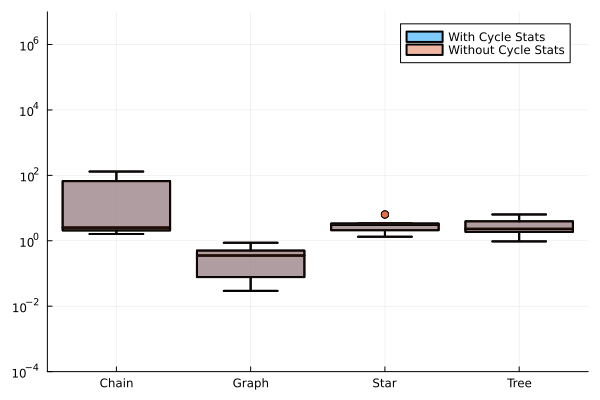

In [38]:
StatsPlots.boxplot(human_query_type, [x[2] for x in human_relative_errors_with_stats],  yscale=:log10, fillalpha=0.5, linewidth=2, label="With Cycle Stats", ylims=[10^-4, 10^7], yticks=[10^-4,10^-2, 1, 10^2, 10^4, 10^6])
StatsPlots.boxplot!(human_query_type, [x[2] for x in human_relative_errors],  yscale=:log10, fillalpha=0.5, linewidth=2, label="Without Cycle Stats")

In [15]:
include("Source/QuasiStableCardinalityEstimator.jl")

aids_query_directories = [
    "/queryset/aids/Chain_3/",
    "/queryset/aids/Chain_6/",
    "/queryset/aids/Chain_9/",
    "/queryset/aids/Chain_12/",
    "/queryset/aids/Cycle_3/",
    "/queryset/aids/Cycle_6/",
    "/queryset/aids/Flower_6/",
    "/queryset/aids/Flower_9/",
    "/queryset/aids/Flower_12/",
    "/queryset/aids/Graph_3/",
    "/queryset/aids/Graph_6/",
    "/queryset/aids/Graph_9/",
    "/queryset/aids/Graph_12/",
    "/queryset/aids/Petal_6/",
    "/queryset/aids/Petal_9/",
    "/queryset/aids/Petal_12/",
    "/queryset/aids/Star_3/",
    "/queryset/aids/Star_6/",
    "/queryset/aids/Star_9/",
    "/queryset/aids/Tree_3/",
    "/queryset/aids/Tree_6/",
    "/queryset/aids/Tree_9/",
    "/queryset/aids/Tree_12/"]
aids_query_paths = [readdir(pwd() * dir, join=true) for dir in aids_query_directories]
aids_query_paths = [(aids_query_paths...)...]
aids_exact_sizes = []
aids_bounds = []
aids_bounds_with_stats = []
aids_relative_errors = []
aids_relative_errors_with_stats = []
aids_query_types = []
println("Summary Size: ", summary_size["aids"])
println("Summary Build Time: ", build_time["aids"])
for query_path in aids_query_paths
    #println("Query: ", query_path)
    id_and_query = load_query(query_path)
    id = id_and_query[1]
    query = id_and_query[2]
    query.graph = bfs_tree(query.graph, 1)
    query_type = match(r".*/queryset/aids/(.*)_.*/.*", query_path).captures[1]
    bound_results = @timed get_cardinality_bounds(query, color_summaries["aids"], usingStoredStats=false)
    bound_results_with_stats = @timed get_cardinality_bounds(query, color_summaries["aids"], usingStoredStats=true)
    gcare_size = load_true_cardinality(replace(query_path, "queryset"=>"TrueCardinalities"))
    exact_size = get_exact_size(query, datasets["aids"])
    bound_results[1][2] = max(1, bound_results[1][2])
    bound_results_with_stats[1][2] = max(1, bound_results_with_stats[1][2])
    push!(aids_exact_sizes, exact_size)
    push!(aids_bounds, bound_results[1])
    push!(aids_bounds_with_stats, bound_results_with_stats[1])
    push!(aids_relative_errors, bound_results[1] ./ exact_size)
    push!(aids_relative_errors_with_stats, bound_results_with_stats[1] ./ exact_size)
    push!(aids_query_types, query_type)
end

Summary Size: nothing
Summary Build Time: 196.9083186

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [24]:
using Statistics
println(maximum([log10(x[2]) for x in aids_relative_errors]))
println(mean([log10(x[2]) for x in aids_relative_errors]))
println(mean([abs(log10(x[2])) for x in aids_relative_errors]))
println(minimum([log10(x[2]) for x in aids_relative_errors]))


MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [25]:
using Statistics
println(maximum([log10(x[2]) for x in aids_relative_errors_with_stats]))
println(mean([log10(x[2]) for x in aids_relative_errors_with_stats]))
println(mean([abs(log10(x[2])) for x in aids_relative_errors_with_stats]))
println(minimum([log10(x[2]) for x in aids_relative_errors_with_stats]))

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

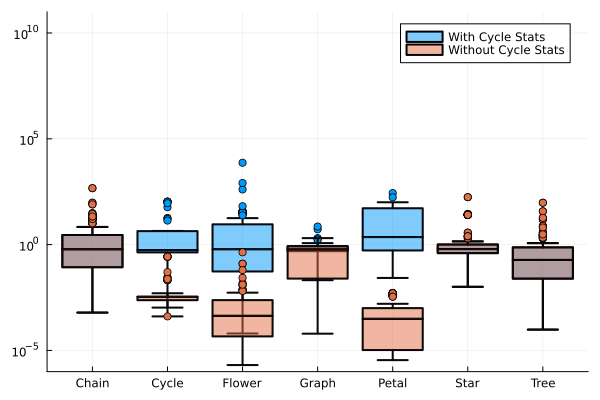

In [18]:
StatsPlots.boxplot(aids_query_types, [x[2] for x in aids_relative_errors_with_stats],  yscale=:log10, fillalpha=0.5, linewidth=2, label="With Cycle Stats", ylims=[10^-6, 10^11], yticks=[10^-5, 1, 10^5, 10^10])
StatsPlots.boxplot!(aids_query_types, [x[2] for x in aids_relative_errors],  yscale=:log10, fillalpha=0.5, linewidth=2, label="Without Cycle Stats")

In [63]:
print(data[!,"QueryType"])

Any["Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain", "Chain

lower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Flower", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "Graph", "G

In [ ]:
lubm80_query_paths = ["lubm80/lubm80_Q2.txt",
# "lubm80/lubm80_Q4.txt",
# "lubm80/lubm80_Q7.txt",
# "lubm80/lubm80_Q8.txt",
# "lubm80/lubm80_Q9.txt",
# "lubm80/lubm80_Q12.txt"
                    ]
exactSizes = []
bounds = []
relativeErrors = []
println("Summary Size: ", summary_size[1])
println("Summary Build Time: ", build_time[1])
for query_path in lubm80_query_paths
    println("Query: ", query_path)
    id_and_query = load_query("queryset/" * query_path)
    id = id_and_query[1]
    query = id_and_query[2]
    bound_results = @timed get_cardinality_bounds(query, color_summaries[1])
    exact_size_results = @timed get_exact_size(query, datasets[1])
    gcare_size = load_true_cardinality("TrueCardinalities/" * query_path)
    println("Bound Time: ", bound_results[2])
    println("Exact Size Time: ", exact_size_results[2])
    println("Exact Size: ", exact_size_results[1])
    println("GCare Exact Size: ", gcare_size)
    if gcare_size != exact_size_results[1]
        println("Bad Exact Size Estimate!!")
        break
    end
    println("Bound [Lower, Avg, Upper]: ", bound_results[1])
    println("Relative Error [Lower, Avg, Upper]: ", (bound_results[1])./exact_size_results[1])
    push!(exactSizes, gcare_size)
    push!(bounds, bound_results[1])
    push!(relativeErrors, bound_results[1] ./ gcare_size)
end

In [ ]:
exactSizes